# 7.8 Lab: Non-linear Modeling 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
%matplotlib inline

/Users/xqiuping/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
"""
In this lab, we will use Wage data. Let us read in the CSV data ans look at a sample of this data.
"""
Wage = pd.read_csv('data/Wage.csv', header=0, na_values='NA')
print Wage.shape
Wage.head()

(3000, 12)


,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## 7.8.1 Polynomial Regression and Step Functions

We will examine how to fit a polynomial regression model on the wage dataset. As all the techniques, we have multiple ways to do this. Here I will use sklearn as we alreadly used statsmodel.api before in Chapter 3.  If you are looking for more built-in functions around p-value, significance, confidence intervie, etc., I would recommend to use statsmodel.api. 

But scikit-learn does not have built error estimates for doing inference. But this problem forces us to think about a more general method to find Confidence Interview (key word: Bootstrap) 

Numpy also has a nice function to do ploynomial regression: https://www.ritchieng.com/machine-learning-polynomial-regression/

In [16]:
n_deg = 4
X = Wage.age
y = Wage.wage
X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

polynomial_features= PolynomialFeatures(degree=n_deg)
X_poly = polynomial_features.fit_transform(X)


reg = LinearRegression()
reg.fit(X_poly, y)

# get coefficients and compare with the numbers as the end of page 288.
print reg.intercept_, reg.coef_

[-184.15417976] [[ 0.00000000e+00  2.12455205e+01 -5.63859313e-01  6.81068771e-03
  -3.20383038e-05]]


/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


We now create a grid of values for age at which we want predictionsm and the call the generic predict() function 

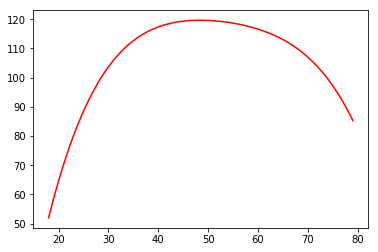

In [17]:
# generate a sequence of age values spanning the range
age_grid = np.arange(Wage.age.min(), Wage.age.max()).reshape(-1,1)

# generate test data use PolynomialFeatures and fit_transform
X_test = PolynomialFeatures(degree=n_deg).fit_transform(age_grid)

# predict the value of the generated ages
y_pred = reg.predict(X_test)

# creating plots
plt.plot(age_grid, y_pred, color='red')
plt.show()

### Decide on the polynomial to use. 

In the book, the authors did this by using hypothesis testing. ANOVA using F-test was explanied. In order
to use the ANOVA function, $M_1$ and $M_2$ must be nested model: the predictors in $M_1$ must be a subset of the predictors in $M_2$. statsmodel.api has a nice built-in function to do that. 

As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using cross-validation, as discussed in before. 

In [18]:
X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)
fit1 = sm.GLS(y, X1).fit()
fit2 = sm.GLS(y, X2).fit()
fit3 = sm.GLS(y, X3).fit()
fit4 = sm.GLS(y, X4).fit()
fit5 = sm.GLS(y, X5).fit()


In [19]:
import statsmodels.api as sm
print(sm.stats.anova_lm(fit1, fit2, fit3, fit4, fit5, typ=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


/Users/xqiuping/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/xqiuping/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/xqiuping/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The row of the above take shows the fit1 to the quadratic model fit2 is $2.36*10^{-32}$, indicating that a quadratic model is significant informative to a linear model. Similarly, the cubic model is significnat informative to a quadratic model ($p = 1.68 * 10^{-2}$).Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In the book, the authors also discussed logistic regression and the polynomial terms. In python, sm.GLM function provided some functions similar to glm() in R.

In [20]:
logistic_model = sm.GLM ((y>250), X4, family=sm.families.Binomial())
logistic_fit = logistic_model.fit()
print(logistic_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Tue, 29 Jan 2019   Deviance:                       701.22
Time:                        17:13:54   Pearson chi2:                 3.70e+03
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.022    -202.956     -16.150
x1             8.9950      4.187      2.148      0.0

### Step function

In order to fit a step function, we use the cut() function:

In [21]:
age_cut, bins = pd.cut(Wage.age, bins=4, retbins=True, right=True)
age_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

Here cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. We could also have specified our own cutpoints directly using the breaks option  (set bins into a sequence of scalars, e.g. [0, 10, 20, 40, 100]). Note in the following code, I manually added a constant column and dropped the lowest value bin (17.938, 33.5] dummy variable.

In [29]:
age_cut_dummies = pd.get_dummies(age_cut)
age_cut_dummies = sm.add_constant(age_cut_dummies)
fit_age_cut = sm.GLM(Wage.wage, age_cut_dummies.drop(age_cut_dummies.columns[1], axis=1)).fit()
print(fit_age_cut.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:              1634.0845923846687
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Tue, 29 Jan 2019   Deviance:                   4.8957e+06
Time:                        17:15:21   Pearson chi2:                 4.90e+06
No. Iterations:                     2                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           94.1584      1.476     63.790      0.000      91.265      97.051
(33.5, 49.0]    24.0535      1.829     13.148 